# Imports

In [1]:
from os import walk
from os.path import join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

from bs4 import BeautifulSoup
from collections import Counter

from sklearn.model_selection import train_test_split

from wordcloud import WordCloud
from PIL import Image
%matplotlib inline

# Constants

In [2]:
EXAMPLE_FILE = 'SpamData/01_Processing/practice_email.txt'
SPAM_1_FILE = 'SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_FILE = 'SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_HAM_1_FILE = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_HAM_2_FILE = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE = 2500

JSON_PATH = 'SpamData/01_Processing/email-text-data.json'
WORD_ID_PATH = 'SpamData/01_Processing/word-by-ids.csv'

TRAINING_DATA_PATH = 'SpamData/02_Training/training-data'
TEST_DATA_PATH = 'SpamData/02_Training/test-data'

WHALE_PATH = 'SpamData/01_Processing/wordcloud_resources/whale-icon.png'
SKULL_PATH = 'SpamData/01_Processing/wordcloud_resources/skull-icon.png'
THUMBS_UP_PATH = 'SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
THUMBS_DOWN_PATH = 'SpamData/01_Processing/wordcloud_resources/thumbs-down.png'
CUSTOM_FONT_PATH = 'SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf'

In [3]:
stream = open(EXAMPLE_FILE, encoding='latin-1')
message = stream.read()
stream.close()

# print(message)

In [4]:
import sys
sys.getfilesystemencoding()

'utf-8'

In [5]:
stream = open(EXAMPLE_FILE)

is_body = False
lines = []

for line in stream:
    if is_body:
        lines.append(line)
    elif '\n' == line:
        is_body = True
    
    
stream.close()

email_body = '\n'.join(lines)
email_body

'\n\nDear Mr Still\n\n\n\nGood tidings to you and all your staff for the festive season ahead (Christmas).\n\nNow to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa\'s Grotto" in your store.\n\nBut WAIT! You\'re probably thinking: "What makes him so special?"\n\nWell, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.\n\nYou will note also, from the enclosed sketch, that I have radically redesigned Santa\'s outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.\n\nI look forward to hearing from you.\n\n\n\nBest wishes\n\nRobin Cooper\n\n[Excerpt from 

# Generator Function

In [6]:
def generator_function(n):
    for i in range(n):
        yield i ** 2

In [7]:
for i in generator_function(1):
    print(i, end=' -> ')

0 -> 

# Email Body Extraction

In [8]:

def email_body_generator(path):
    for root, dirnames, filenames in walk(path):
        for file_name in filenames:
            
            file_path = join(root, file_name)
            
            stream = open(file_path, encoding='latin-1')
            
            is_body = False
            lines = []
            
            for line in stream:
                if is_body:
                    lines.append(line)
                elif '\n' == line:
                    is_body = True
                    
            stream.close()
            
            email_body = '\n'.join(lines)
            
            yield file_name, email_body
    


In [9]:
def df_from_directory(path, classification):
    rows=[]
    rows_name = []
    for file_name, email_body in email_body_generator(path):
        rows_name.append(file_name)
        rows.append({ 'Category' : classification, 'Message' : email_body})
        
    return pd.DataFrame(data=rows, index=rows_name)
        

In [10]:
spam_emails = df_from_directory(SPAM_1_FILE, SPAM_CAT)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_FILE, SPAM_CAT))
spam_emails.head()

,Category,Message
00001.7848dde101aa985090474a91ec93fcf0,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr..."
00002.d94f1b97e48ed3b553b3508d116e6a09,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...
00003.2ee33bc6eacdb11f38d052c44819ba6c,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...
00004.eac8de8d759b7e74154f142194282724,1,##############################################...
00005.57696a39d7d84318ce497886896bf90d,1,I thought you might like these:\n\n1) Slim Dow...


In [11]:
spam_emails.shape

(1900, 2)

In [12]:
non_spam_emails = df_from_directory(EASY_HAM_1_FILE, HAM_CAT)
non_spam_emails = non_spam_emails.append(df_from_directory(EASY_HAM_2_FILE, HAM_CAT))
non_spam_emails.head()

,Category,Message
00001.7c53336b37003a9286aba55d2945844c,0,"Date: Wed, 21 Aug 2002 10:54:46 -05..."
00002.9c4069e25e1ef370c078db7ee85ff9ac,0,"Martin A posted:\n\nTassos Papadopoulos, the G..."
00003.860e3c3cee1b42ead714c5c874fe25f7,0,Man Threatens Explosion In Moscow \n\n\n\nThur...
00004.864220c5b6930b209cc287c361c99af1,0,Klez: The Virus That Won't Die\n\n \n\nAlready...
00005.bf27cdeaf0b8c4647ecd61b1d09da613,0,"> in adding cream to spaghetti carbonara, whi..."


In [13]:
non_spam_emails.shape

(3902, 2)

In [14]:
data = pd.concat([spam_emails, non_spam_emails])
data.head()

,Category,Message
00001.7848dde101aa985090474a91ec93fcf0,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr..."
00002.d94f1b97e48ed3b553b3508d116e6a09,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...
00003.2ee33bc6eacdb11f38d052c44819ba6c,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...
00004.eac8de8d759b7e74154f142194282724,1,##############################################...
00005.57696a39d7d84318ce497886896bf90d,1,I thought you might like these:\n\n1) Slim Dow...


In [15]:
data.tail()

,Category,Message
01396.61983fbe6ec43f55fd44e30fce24ffa6,0,http://news.bbc.co.uk/1/hi/england/2515127.stm...
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7,0,"> >-- be careful when using this one.) Also, t..."
01398.169b51731fe569f42169ae8f948ec676,0,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ..."
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896,0,"So then, ""Mark Hammond"" <mhammond@skippinet.co..."
01400.f897f0931e461e7b2e964d28e927c35e,0,"Hi there,\n\n\n\nNow this is probably of no us..."


# Cleaning Data

In [16]:
# checking for null value in email body
data.Message.isnull().values.any()


False

In [17]:
#checking for message to be empty string
(data.Message.str.len() == 0).any()

True

In [18]:
(data.Message.str.len() == 0).sum()

3

In [19]:
data.Message.str == None

False

## location of empty message

In [20]:
type(data.Message.str.len() == 0)

pandas.core.series.Series

In [21]:
# knowing the filename 
data[data.Message.str.len() == 0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [22]:
# position of filename
data.index.get_loc('cmds')

array([False, False, False, ..., False, False, False])

In [23]:
data[4608:4611]

,Category,Message
00207.b9d4e94f1d5159f207cfe562194ab0c6,0,"On Thu, 1 Aug 2002 17:15:27 +0100 \n\n""John P...."
00208.d44ac6333a9b4ad601299143998097b9,0,"On Thu, Aug 01, 2002 at 04:03:07PM +0100, Padr..."
00209.3ebcc564b5a595d391416cba9d0696d0,0,"On Thu, Aug 01, 2002 at 05:41:03PM +0100, Paul..."


## Droping the sys file entries form dataframe

In [24]:
data.drop(['cmds'], inplace=True)
data.shape # 3files are droped

(5799, 2)

# Add Document Id's to track email in data

In [25]:
data['DOC_ID'] = range(0, len(data.index))
data['FILE_NAME'] = data.index

In [26]:
data.set_index('DOC_ID', inplace=True)
data.head()

,Category,Message,FILE_NAME
DOC_ID,,,
0,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",00001.7848dde101aa985090474a91ec93fcf0
1,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,1,##############################################...,00004.eac8de8d759b7e74154f142194282724
4,1,I thought you might like these:\n\n1) Slim Dow...,00005.57696a39d7d84318ce497886896bf90d


In [27]:
data.tail()

,Category,Message,FILE_NAME
DOC_ID,,,
5794,0,http://news.bbc.co.uk/1/hi/england/2515127.stm...,01396.61983fbe6ec43f55fd44e30fce24ffa6
5795,0,"> >-- be careful when using this one.) Also, t...",01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7
5796,0,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",01398.169b51731fe569f42169ae8f948ec676
5797,0,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",01399.ca6b00b7b341bbde9a9ea3dd6a7bf896
5798,0,"Hi there,\n\n\n\nNow this is probably of no us...",01400.f897f0931e461e7b2e964d28e927c35e


# Saving file on JSON

In [28]:
data.to_json(JSON_PATH)

## visualizing data with pie-chart

In [29]:
data.Category.value_counts()

0    3901
1    1898
Name: Category, dtype: int64

In [30]:
spam_msg = data.Category.value_counts()[1]
ham_msg = data.Category.value_counts()[0]

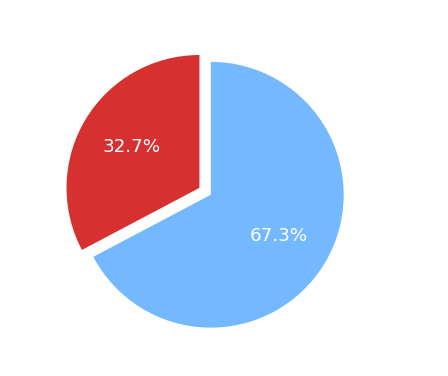

In [31]:
size = [spam_msg, ham_msg]
category = ['Spam', 'Legit mail']
custom_colors = ['#d63031', '#74b9ff']

plt.figure(figsize=(2,2), dpi=220)
plt.pie(size, labels=category, textprops={'fontsize': 6, 'color': 'white'}, startangle=90, autopct='%1.1f%%', explode=[0,0.1],
       colors=custom_colors)
plt.show()

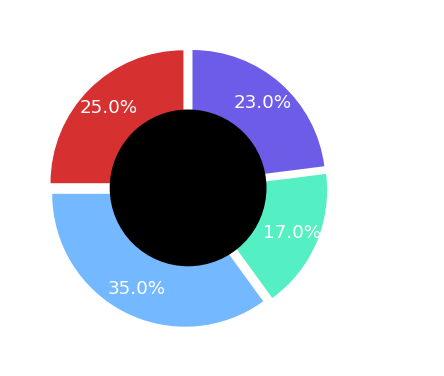

In [32]:
size = [25,35,17,23]
category = ['Spam', 'Legit mail', 'promotion', 'updates']
custom_colors = ['#d63031', '#74b9ff', '#55efc4', '#6c5ce7']
offset = [0.05,0.05,0.05,0.05]

plt.figure(figsize=(2,2), dpi=220)
plt.pie(size, labels=category, textprops={'fontsize': 6, 'color': 'white'}, startangle=90, autopct='%1.1f%%',pctdistance=0.8,
       colors=custom_colors, explode=offset)
#creating donut chart
#creating circle 
centre_circle = plt.Circle(xy = (0,0), radius=0.59, fc='black')
plt.gca().add_artist(centre_circle)
plt.show()

# Natural Language Processing

### pre-processing data

In [33]:
#example converting to lower
msg = 'All work and no play makes Jack a dull boy.'
msg.lower()

'all work and no play makes jack a dull boy.'

### Downloads the nltk resources (tokenizer & stopwords)

In [34]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Siraj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [35]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Siraj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [36]:
nltk.download('gutenberg')
nltk.download('shakespeare')

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\Siraj\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package shakespeare to
[nltk_data]     C:\Users\Siraj\AppData\Roaming\nltk_data...
[nltk_data]   Package shakespeare is already up-to-date!


True

### Tokenising

In [37]:
word_tokenize(msg)

['All', 'work', 'and', 'no', 'play', 'makes', 'Jack', 'a', 'dull', 'boy', '.']

### Removing stopwords

In [38]:
stop_words = set(stopwords.words('english'))

In [39]:
if 'hwllo' in stop_words:
    print ('found it!')
else:
    print('nope. not found')

nope. not found


In [40]:
if 'hello' not in stop_words: print('nope. not here!')

nope. not here!


In [41]:
msg = 'All work and no play makes Jack a dull boy. to be or not to be.'
words = word_tokenize(msg)
filtered_words = []
for i in words:
    if i not in stop_words:
        filtered_words.append(i)

filtered_words

['All', 'work', 'play', 'makes', 'Jack', 'dull', 'boy', '.', '.']

### Word Stem & Stemming

In [42]:
msg = 'All work and no play makes Jack a dull boy. to be or not to be . \
       Nobody expects the Spanish Inquisition!'
words = word_tokenize(msg)
filtered_words = []
stemmer = PorterStemmer()

for word in words:
    if word not in stop_words:
        stemmer_word = stemmer.stem(word)
        filtered_words.append(stemmer_word)

print(filtered_words)

['all', 'work', 'play', 'make', 'jack', 'dull', 'boy', '.', '.', 'nobodi', 'expect', 'spanish', 'inquisit', '!']


### Removing Punctuation

In [43]:
'A'.isalpha()

True

In [44]:
'.'.isalpha()

False

In [45]:
msg = 'All work and no play makes Jack a dull boy. to be or not to be . ???\
       Nobody expects the Spanish Inquisition!'
words = word_tokenize(msg)
filtered_words = []
stemmer = SnowballStemmer('english')

for word in words:
    if word not in stop_words and word.isalpha():
        stemmer_word = stemmer.stem(word)
        filtered_words.append(stemmer_word)
            

print(filtered_words)

['all', 'work', 'play', 'make', 'jack', 'dull', 'boy', 'nobodi', 'expect', 'spanish', 'inquisit']


### Removing HTML tags from emails

In [46]:
soup = BeautifulSoup(data.Message[213], 'html.parser')
# print(soup.prettify())

In [47]:
soup.get_text()

'This is a multi-part message in MIME format.\n\n\n\n------=_NextPart_000_1CDC19_01C25366.4B57F3A0\n\nContent-Type: text/plain;\n\n\tcharset="Windows-1252"\n\nContent-Transfer-Encoding: quoted-printable\n\n\n\n We dare you...\n\n Try to find a better annuity!\n\n=20\n\n  - 5.40% Guaranteed for 6 Years=0A=\n\n- 6 Year Surrender Charge=0A=\n\n- 5% Agent\n\nCommission up to age 80=09\n\nCall today for more information!\n\n 800-888-7641 ext. 103\n\n- or -\n\n\n\nPlease fill out the form below for more information\t=20\n\nName:\t \t  =09\n\nE-mail:\t \t=20\n\nPhone:\t \t=20\n\nCity:\t \t State:\t \t=20\n\n \t    =09\n\n=20\n\n PMG Financial Services\n\n*5.40% for deposits of $100,000 and up, 5.25% interest for deposits\n\ntotalling $25,000-$99,999.\t=20\n\nWe don\'t want anyone to receive our mailings who does not wish to\n\nreceive them. This is a professional communication sent to insurance\n\nprofessionals. To be removed from this mailing list, DO NOT REPLY to\n\nthis message. Instead, g

### Python Function for email processing

In [48]:
def clean_msg(message, stemmer = PorterStemmer(),
                     stop_words = set(stopwords.words('english'))):
    
    #converts to lower case and split into individual words
    words = word_tokenize(message.lower())

    filtered_words = []
    
    for word in words:
        # Reamoves the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
            
            
    return filtered_words  
    

In [49]:
def clean_msg_no_html(message, stemmer = PorterStemmer(),
                     stop_words = set(stopwords.words('english'))):
    #remove html tags
    soup = BeautifulSoup(message, 'html.parser')
    new_email = soup.get_text()
    
    #converts to lower case and split into individual words
    words = word_tokenize(new_email.lower())

    filtered_words = []
    
    for word in words:
        # Reamoves the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
            # filtered_words.append(word)
            
            
    return filtered_words   
    

In [50]:
print(clean_msg_no_html(data.Message[213]))

['messag', 'mime', 'format', 'dare', 'tri', 'find', 'better', 'annuiti', 'guarante', 'year', 'surrend', 'agent', 'commiss', 'age', 'call', 'today', 'inform', 'ext', 'pleas', 'fill', 'form', 'inform', 'name', 'phone', 'citi', 'state', 'pmg', 'financi', 'servic', 'deposit', 'interest', 'deposit', 'total', 'want', 'anyon', 'receiv', 'mail', 'wish', 'receiv', 'profession', 'commun', 'sent', 'insur', 'profession', 'remov', 'mail', 'list', 'repli', 'messag', 'instead', 'go', 'http', 'legal', 'notic', 'dare', 'find', 'better', 'annuiti', 'call', 'today', 'inform', 'pleas', 'fill', 'form', 'inform', 'name', 'phone', 'citi', 'state', 'deposit', 'interest', 'deposit', 'total', 'want', 'anyon', 'receiv', 'mail', 'wish', 'receiv', 'profession', 'sent', 'insur', 'profession', 'remov', 'list', 'repli', 'messag', 'instead', 'go', 'http', 'legal', 'notic']


## Cleaning and tokenizing all the data
### slicing dataframe & series and Creating subsets

In [51]:
data.iat[2, 2]

'00003.2ee33bc6eacdb11f38d052c44819ba6c'

In [52]:
data.iloc[5:11]

,Category,Message,FILE_NAME
DOC_ID,,,
5,1,A POWERHOUSE GIFTING PROGRAM You Don't Want To...,00006.5ab5620d3d7c6c0db76234556a16f6c1
6,1,Help wanted. We are a 14 year old fortune 500...,00007.d8521faf753ff9ee989122f6816f87d7
7,1,<html>\n\n<head>\n\n<title>ReliaQuote - Save U...,00008.dfd941deb10f5eed78b1594b131c9266
8,1,TIRED OF THE BULL OUT THERE?\n\nWant To Stop L...,00009.027bf6e0b0c4ab34db3ce0ea4bf2edab
9,1,"Dear ricardo1 ,\n\n\n\n<html>\n\n<body>\n\n<ce...",00010.445affef4c70feec58f9198cfbc22997
10,1,Cellular Phone Accessories All At Below Wholes...,00011.61816b9ad167657773a427d890d0468e


In [53]:
first_emails = data.Message.iloc[0:3]

nested_list = first_emails.apply(clean_msg)

In [54]:
# flat_list = []
# for sublist in nested_list:
#     for item in sublist:
#         flat_list.append(item)

flat_list = [item for sublist in nested_list for item in sublist] #list comprehension
len(flat_list)

321

In [55]:
%%time

nested_list = data.Message.apply(clean_msg_no_html)  # applying data straight to generator function 

D:\anaconda3\lib\site-packages\bs4\__init__.py:431: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


Wall time: 30.9 s


In [56]:
nested_list.tail()

DOC_ID
5794    [http, bizarr, collect, stuf, anim, could, fet...
5795    [care, use, one, also, realli, cute, thing, ja...
5796    [sm, skip, montanaro, write, jeremi, put, anot...
5797    [mark, hammond, like, given, zodb, sound, attr...
5798    [hi, probabl, use, whatsoev, also, problem, re...
Name: Message, dtype: object

### Using logic to slice dataframes

In [57]:
data[data.Category == 1].shape # all spam emails

(1898, 3)

In [58]:
data[data.Category == 1].index #index of all spam emails

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1888, 1889, 1890, 1891, 1892, 1893, 1894, 1895, 1896, 1897],
           dtype='int64', name='DOC_ID', length=1898)

In [59]:
doc_id_spam = data[data.Category == 1].index
doc_id_ham = data[data.Category == 0].index

In [60]:
doc_id_ham

Int64Index([1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907,
            ...
            5789, 5790, 5791, 5792, 5793, 5794, 5795, 5796, 5797, 5798],
           dtype='int64', name='DOC_ID', length=3901)

### Subsetting a series with idex

In [61]:
ham_nested_list = nested_list.loc[doc_id_ham]   # taking ham email through indexing 
spam_nested_list = nested_list.loc[doc_id_spam] 

In [62]:
%%time

spam_list= [item for sublist in spam_nested_list for item in sublist]  #list comprehension using loop
spam_words = pd.Series(spam_list).value_counts()
ham_list = [item for sublist in ham_nested_list for item in sublist]
normal_words = pd.Series(ham_list).value_counts()

Wall time: 210 ms


In [63]:
normal_words.shape[0], spam_words.shape[0] #no of unique words in list

(20815, 13242)

In [64]:
# total_spam_word_count = Counter(spam_list)
# top_spam_words =total_spam_word_count.most_common(10)
# total_ham_word_count = Counter(ham_list)
# top_ham_words = total_ham_word_count.most_common(10)

normal_words[:10] , spam_words[:10] # most common words 

(http      7564
 use       3635
 list      2881
 one       2375
 get       2287
 mail      2256
 would     2003
 like      1932
 messag    1849
 work      1801
 dtype: int64,
 http      3106
 email     3090
 free      2587
 click     2058
 receiv    1989
 list      1973
 get       1915
 pleas     1854
 busi      1792
 order     1746
 dtype: int64)

## generating WordClouds

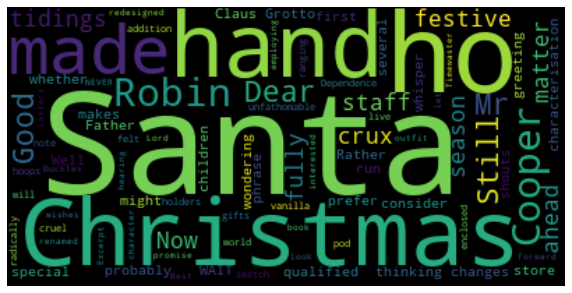

In [65]:
word_cloud = WordCloud().generate(email_body)
plt.figure(figsize=(10,6))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [66]:
example_corpus = nltk.corpus.gutenberg.words('melville-moby_dick.txt') #extracting from path file
type(example_corpus)

nltk.corpus.reader.util.StreamBackedCorpusView

In [67]:
word_list = [''.join(item) for item in example_corpus] #converting streamBackedCorpusView to list
novel_as_string = ' '.join(word_list) #joining all the words with space

In [68]:
type(word_list)

list

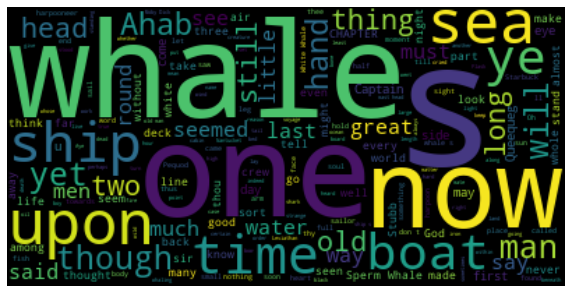

In [69]:
word_cloud = WordCloud().generate(novel_as_string)
plt.figure(figsize=(10,6))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

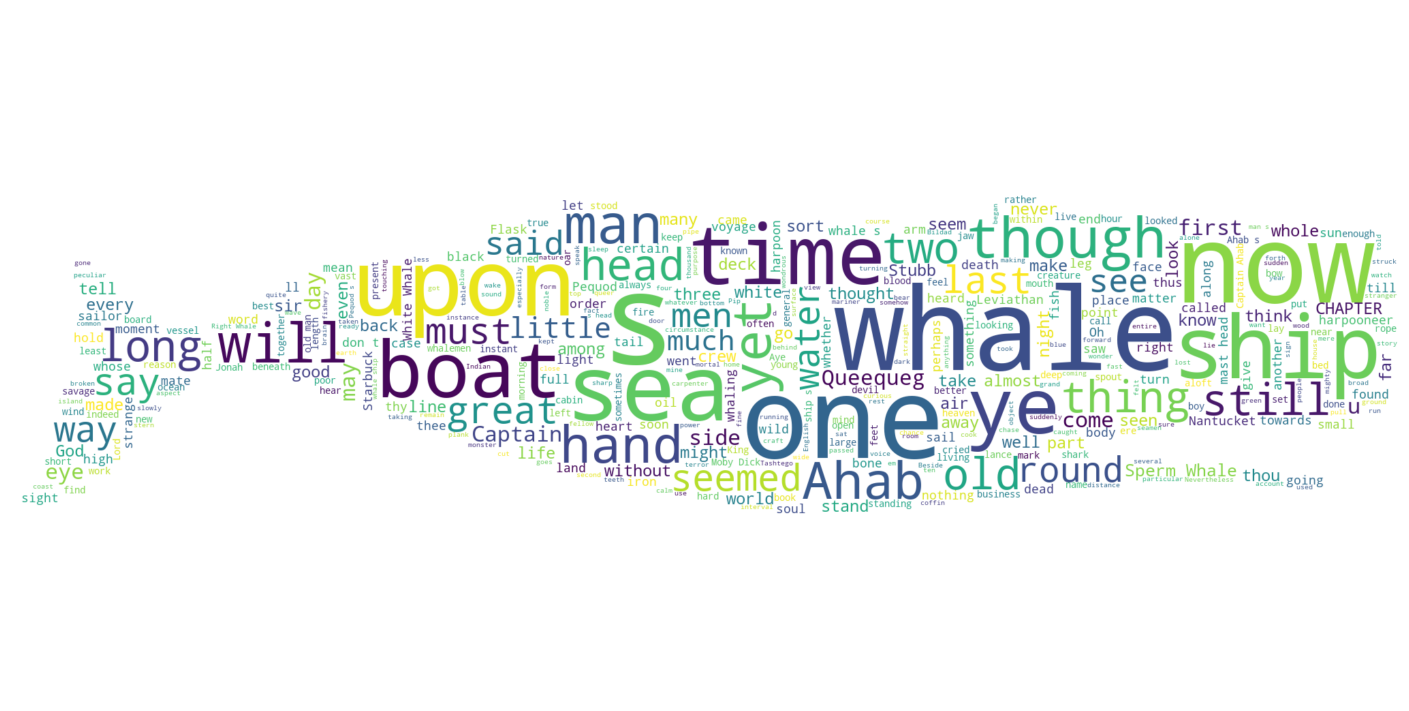

In [70]:
whale = Image.open(WHALE_PATH) #opening the image from path
image_mask = Image.new(mode='RGB', size=whale.size, color=(255, 255, 255)) #creating a new canvas of same size
image_mask.paste(whale, box=whale) # pasting the whale image in canvas as mask

rgb_array = np.array(image_mask) # converting image to numbers array

word_cloud = WordCloud(mask=rgb_array, background_color='white', max_words=400,
                       )
word_cloud.generate(novel_as_string)
plt.figure(figsize=(25,20))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

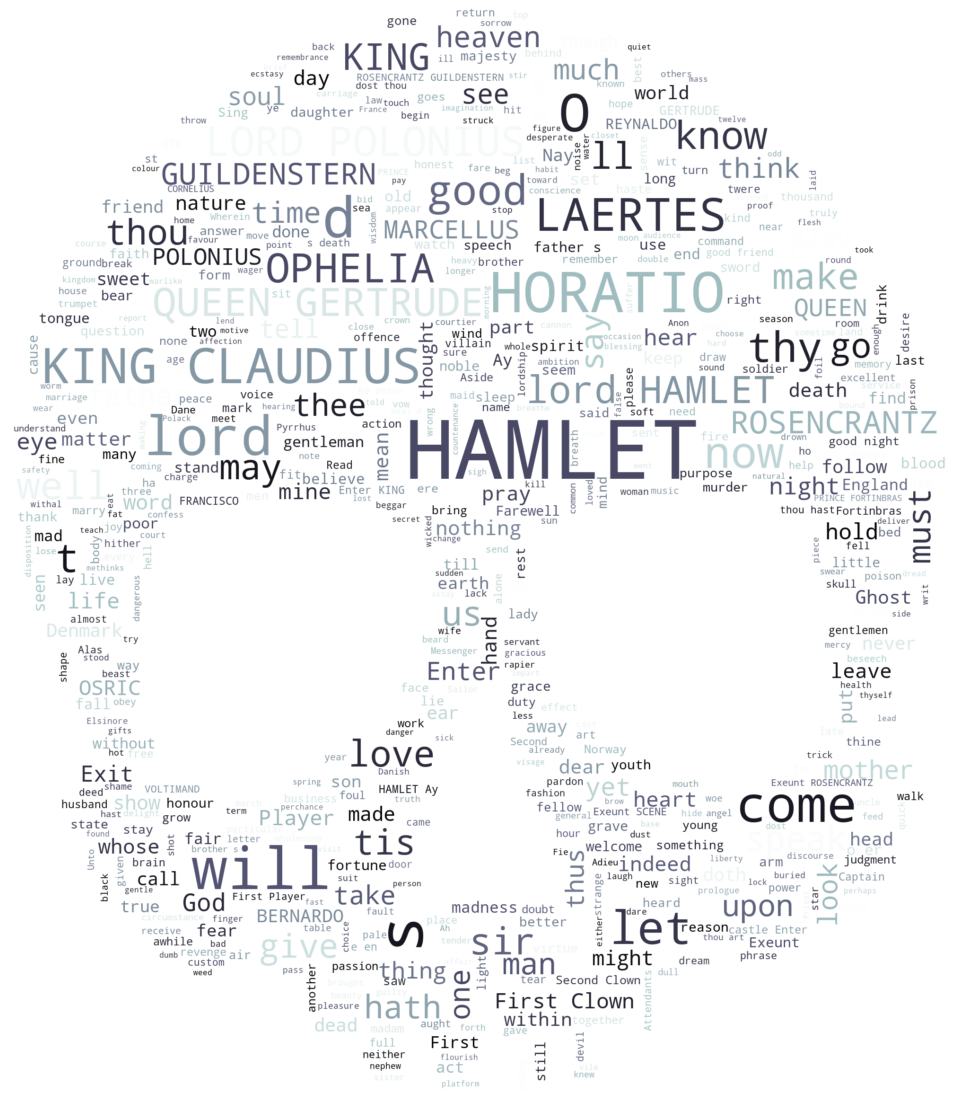

In [71]:
skull = Image.open(SKULL_PATH)
image_mask = Image.new(mode='RGB', size=skull.size, color=(255,255,255))
image_mask.paste(skull, box=skull)

rgb_array = np.array(image_mask)

# tokenization
example_corpus = nltk.corpus.shakespeare.words('hamlet.xml')

novel_as_string = ' '.join(example_corpus)

word_cloud = WordCloud(mask=rgb_array, background_color='white',
                       colormap='bone', max_words=600,
                       )
word_cloud.generate(novel_as_string)
plt.figure(figsize=(25,20))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Spam and legit message WordCloud

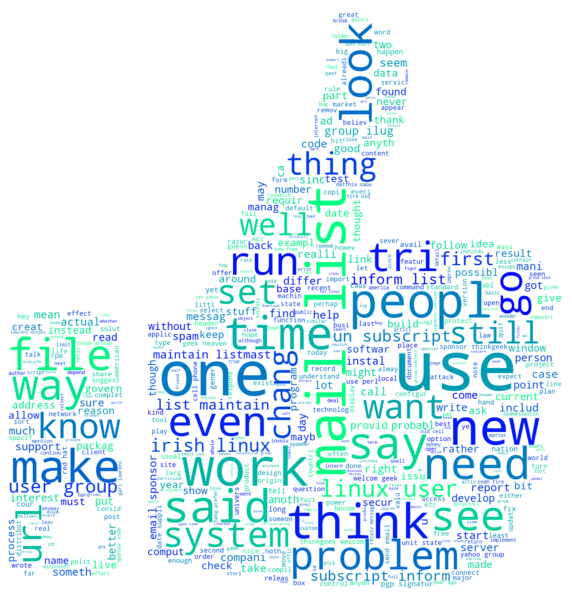

In [72]:
fig = Image.open(THUMBS_UP_PATH)
image_mask = Image.new(mode='RGB', size=fig.size, color=(255,255,255))
image_mask.paste(fig, box=fig)

rgb_array = np.array(image_mask)

novel_as_string = ' '.join(ham_list)

word_cloud = WordCloud(mask=rgb_array, background_color='white', 
                       colormap='winter', max_words=500,)
word_cloud.generate(novel_as_string)
plt.figure(figsize=(10,20))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

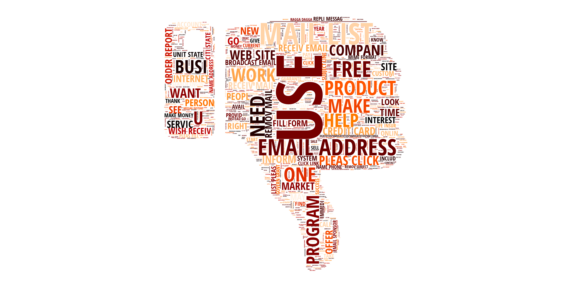

In [73]:
fig = Image.open(THUMBS_DOWN_PATH)
image_mask = Image.new(mode='RGB', size=fig.size, color=(255,255,255))
image_mask.paste(fig, box=fig)

rgb_array = np.array(image_mask)


novel_as_string = ' '.join(spam_list)

word_cloud = WordCloud(mask=rgb_array, background_color='white', font_path=CUSTOM_FONT_PATH,
                       colormap='gist_heat', max_words=2000,max_font_size=300)
word_cloud.generate(novel_as_string.upper())
plt.figure(figsize=(10,20))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Generate Vocbulary & Dictionary

In [74]:
stemmed_nested_list = data.Message.apply(clean_msg_no_html)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

In [75]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
frequent_words = unique_words.iloc[0:VOCAB_SIZE]

## Vocab Dataframe

In [76]:
word_ids = list(range(0, VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_NAME' : frequent_words.index}, index=word_ids)
vocab.index.name = 'WORD_IDS'
vocab.head()

,VOCAB_NAME
WORD_IDS,
0,http
1,use
2,list
3,email
4,get


## CSV file of dataframe

In [77]:
vocab.to_csv(WORD_ID_PATH, index_label=vocab.index.name, header=vocab.VOCAB_NAME.name)

In [78]:
## check word in vocabulary
def check(word):
    # result = vocab[vocab.VOCAB_NAME == word].any().values[0] #inefficient
    # result = any(vocab.VOCAB_NAME == word) #inefficient
    result = word in set(vocab.VOCAB_NAME)
    return result

In [79]:
check('machine'), check('learning'), check('fun'),check('learn'),check('data'),check('science'),check('app'),check('brew')

(False, False, True, True, True, False, True, False)

In [80]:
## check length of email
length = [len(sublist) for sublist in stemmed_nested_list ]
max(length)
# count =-1
# for i in length:
#     count += 1
#     if i == max(length):
#         break
# print(count)
np.argmax(length)

# data.at[np.argmax(length), 'Message']

5778

In [81]:
len(max(stemmed_nested_list,key=len))
len(max(data.Message,key=len))

234358

 ## Generating Features & a Sparse Matrix
    
### Creating DataFrame with one word per column

In [82]:
word_columns_df = pd.DataFrame.from_records( stemmed_nested_list.tolist())

In [83]:
#splitting data into training set and test set
X_train, X_test, y_train, y_test= train_test_split(word_columns_df, data.Category, train_size=0.7, random_state=42)
X_train.index.name = X_test.index.name = 'DOC_ID'

In [84]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4100,url,http,date,suppli,key,encod,photon,light,sent,kilometr,...,None,None,None,None,None,None,None,None,None,None
5233,dave,long,write,also,strike,long,livestock,genet,engin,dumber,...,None,None,None,None,None,None,None,None,None,None
5072,thu,jul,matthia,saou,wrote,upon,time,matthia,wrote,see,...,None,None,None,None,None,None,None,None,None,None
1293,lose,weight,natur,lose,weight,safe,lose,weight,fast,extrem,...,None,None,None,None,None,None,None,None,None,None
4357,us,lister,recognis,damian,lewi,winter,band,brother,annoy,one,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,url,http,date,tue,sep,gmt,overwork,world,web,develop,...,None,None,None,None,None,None,None,None,None,None
5191,tue,aug,edt,said,ever,tri,get,mh,sequenc,suspect,...,None,None,None,None,None,None,None,None,None,None
5226,string,joke,piec,string,friend,walk,bar,barman,say,sorri,...,None,None,None,None,None,None,None,None,None,None


In [85]:
y_train

DOC_ID
4100    0
5233    0
5072    0
1293    1
4357    0
       ..
3772    0
5191    0
5226    0
5390    0
860     1
Name: Category, Length: 4059, dtype: int64

In [86]:
X_test.shape[0]/word_columns_df.shape[0]

0.3000517330574237

### Creating sparse matrix for traning data

In [87]:
X_train.head()
X_train.index[2], y_train.at[4100]

(5072, 0)

In [88]:
word_index = pd.Index(vocab.VOCAB_NAME)
word_index.get_loc('thu')

393

In [89]:
X_train.iat[0,0]

'url'

In [90]:
# creating sparse matrix
def make_sparse_matrix(df, labels, indexed_word):
    '''
    gives a sparse matrix dataframe.
    
    df : DataFrame with words in column with doc_id as index (X_train, X_test)
    label: Spam or not, category as series(y_train, y_test)
    indexed_word : index of word_index(pd.index(vocab.VOCAB_NAME))
    '''
    nr_row = df.shape[0]
    nr_column = df.shape[1]
    word_set = set(indexed_word)
    dict_list = []
    
    for i in range(nr_row):
        for j in range(nr_column):
            word = df.iat[i,j]
            if word in word_set:
                doc_id = df.index[i]
                occurence = 1
                category = labels.at[doc_id]
                word_id = indexed_word.get_loc(word)
                item = {'DOC_ID' : doc_id, 'Occurence': occurence, 'Label': category, 'WORD_ID':word_id}
                dict_list.append(item)
    
    return pd.DataFrame(dict_list)

In [91]:
%%time
sparse_train_df = make_sparse_matrix(X_train, y_train, word_index)

Wall time: 17min 31s


In [92]:
sparse_train_df.shape, sparse_train_df.head()


((450820, 4),
    DOC_ID  Occurence  Label  WORD_ID
 0    4100          1      0      109
 1    4100          1      0        0
 2    4100          1      0       76
 3    4100          1      0      339
 4    4100          1      0      384)

### Combine Occurences with Pandas groupby() Method

In [93]:
train_grouped = sparse_train_df.groupby(['DOC_ID', 'Label', 'WORD_ID']).sum()
train_grouped.head()

Occurence
DOC_ID Label WORD_ID           
0      1     2                1
             3                2
             4                1
             7                3
             11               1

In [94]:
vocab.VOCAB_NAME.at[7]

'free'

In [95]:
data.Message[0]

'<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN">\n\n<HTML><HEAD>\n\n<META content=3D"text/html; charset=3Dwindows-1252" http-equiv=3DContent-T=\n\nype>\n\n<META content=3D"MSHTML 5.00.2314.1000" name=3DGENERATOR></HEAD>\n\n<BODY><!-- Inserted by Calypso -->\n\n<TABLE border=3D0 cellPadding=3D0 cellSpacing=3D2 id=3D_CalyPrintHeader_ r=\n\nules=3Dnone \n\nstyle=3D"COLOR: black; DISPLAY: none" width=3D"100%">\n\n  <TBODY>\n\n  <TR>\n\n    <TD colSpan=3D3>\n\n      <HR color=3Dblack noShade SIZE=3D1>\n\n    </TD></TR></TD></TR>\n\n  <TR>\n\n    <TD colSpan=3D3>\n\n      <HR color=3Dblack noShade SIZE=3D1>\n\n    </TD></TR></TBODY></TABLE><!-- End Calypso --><!-- Inserted by Calypso=\n\n --><FONT \n\ncolor=3D#000000 face=3DVERDANA,ARIAL,HELVETICA size=3D-2><BR></FONT></TD><=\n\n/TR></TABLE><!-- End Calypso --><FONT color=3D#ff0000 \n\nface=3D"Copperplate Gothic Bold" size=3D5 PTSIZE=3D"10">\n\n<CENTER>Save up to 70% on Life Insurance.</CENTER></FONT><FONT color=3D#ff=\n\n0000

In [96]:
train_grouped = train_grouped.reset_index()

In [97]:
train_grouped.head()

,DOC_ID,Label,WORD_ID,Occurence
0,0,1,2,1
1,0,1,3,2
2,0,1,4,1
3,0,1,7,3
4,0,1,11,1


In [98]:
train_grouped.shape

(265428, 4)

## saving file to .txt file 

In [99]:
np.savetxt(TRAINING_DATA_PATH, train_grouped, fmt='%d')

In [100]:
train_grouped.columns

Index(['DOC_ID', 'Label', 'WORD_ID', 'Occurence'], dtype='object')

### sparse matrix for test data

In [ ]:
sparse_test_df = make_sparse_matrix(X_test, y_test, word_index)

In [ ]:
sparse_test_df.tail()

In [ ]:
test_grouped = sparse_test_df.groupby(['DOC_ID', 'Label', 'WORD_ID']).sum()

In [ ]:
test_grouped = test_grouped.reset_index()
test_grouped.head()

In [ ]:
vocab.VOCAB_NAME.at[3]

In [ ]:
data.Message[8]

In [ ]:
#saving to txt
np.savetxt(TEST_DATA_PATH, test_grouped, fmt='%d')

In [ ]:
test_grouped.columns

### Pre-Processing subtleties and checking understanding

In [ ]:
test_grouped.DOC_ID.value_counts().shape, X_test.shape

In [ ]:
X_test.index

In [ ]:
test_grouped.DOC_ID.value_counts().index

In [ ]:
%%time
# count = 0
# for i in range(test_grouped.DOC_ID.value_counts().shape[0]):
#     if X_test.index[i] not in test_grouped.DOC_ID.value_counts().index:
#         print(X_test.index[i])

set(X_test.index) - set(test_grouped.DOC_ID.value_counts().index)

In [ ]:
data.loc[134]

In [ ]:
clean_msg_no_html(data.Message.at[134]) #empty means its body is html mostly